<center>
<h1>CSCI3151 - Foundations of Machine Learning</h1>
<h1>Assignment 2</h1>
Summer 2021
</center>

<center>
<b> Due on: 25 June 2021, 23:30 ADT  </b> 
</center>

Your assignment is to be submitted as a single `.ipynb` file **(please do not zip it when submitting to brightspace)** including your answers to both the math and the experimental questions, in the correct order, on Brightspace. Use [markdown syntax](https://www.markdownguide.org/cheat-sheet/) to format your answers

Note: in solving the math questions, aim for general (symbolic) solutions and substitute the specific numbers at the end. This demonstrates a solid understanding of the key concepts. 
You can answer the math questions in two ways:
*   **Use LaTeX to typeset the equations**. Section H of [this LaTeX reference sheet](http://tug.ctan.org/info/latex-refsheet/LaTeX_RefSheet.pdf) is a good reference. Here is another [LaTeX reference sheet](https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference).
The equations in the questions are typeset in LaTeX, so you can use them as examples. 
*   **Use neat handwriting**, scan your solution using [Camscanner](https://www.camscanner.com/user/download) on your mobile phone, upload the image file, and embed it in your solution notebook. To this end (1) create an empty Markdown cell. 2) Drag-and-drop the image file into the empty Markdown cell, or click on the image icon at the top of the cell and select the image file. The Markdown code that will embed the image, together with its content, then appears.   


Your answers to the experimental questions should be in your solution notebook, in the form of code and text cells, using markdown for your text responses. You should also include the results of running your code. 

The marking criteria are described in rubrics. There are two rubrics, for math questions, and for experimental questions, respectively. 

You can submit multiple editions of your assignment. Only the last one will be marked. It is recommended to upload a complete submission, even if you are still improving it, so that you have something into the system if your computer fails for whatever reason.  

**IMPORTANT**: PLEASE NAME YOUR PYTHON NOTEBOOK FILE AS: 
* `<LAST_NAME>-<FIRST_NAME>-Assignment-N.ipynb`

for example: **Milios-Evangelos-Assignment-2.ipynb** \\


## **1. Gradient descent - Logistic regression**









 

In this question we are going to experiment with logistic regression. This exercise focuses on the inner workings of gradient descent using a cross-entropy cost function as it was learned in class.

a) Using the [Pima Indians Diabetes Dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database), first apply a feature selection algorithm based on evaluating feature importance using [Pearson correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) (see <a href=https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.pearsonr.html>scipy documentation</a>). Extract the top two most important features based on this measure. Then, separate a random 20% of your data instances for validation.


In [28]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [29]:
# Load modules.
import pandas as pd
import numpy as np
from sklearn import model_selection
from scipy import stats

def init(file_name: str = "/content/drive/MyDrive/diabetes.csv", number_of_features=2, with_bias=True, verbose=True):
    """
        @param file_name: Indicates name of data set to load.
        @param number_of_features: Indicates number of features to choose based on Pearson correlation.
        @returns: A tuple containing X_test, X_train, Y_test, Y_train.
    """
    # Load data set.
    df = pd.read_csv(file_name)
    
    # Extract all feature names.
    X = df.drop("Outcome", axis = 1)
    Y = df["Outcome"]

    # Get column names.
    labels = X.columns

    # Convert data to numpy arrays.
    X = X.to_numpy()
    Y = Y.to_numpy()

    # Determine most important features.
    r_vals = [stats.pearsonr(x, Y)[0] for x in X.T]
    features_to_use = np.argsort(r_vals)[-number_of_features:]
    features_to_use_labels = [labels[x] for x in features_to_use]

    # Output labels.
    if verbose:
        print(f"Features being used: {features_to_use_labels}")

    # Retrieve data from X that uses columns from the most important features.
    X = df.iloc[:, features_to_use].to_numpy()
    
    if with_bias:
        X = np.c_[np.ones((len(X), 1)), X]

    # Split X and Y into testing and training sets.
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)
    
    return X_train, X_test, Y_train, Y_test

b) We want to train a logistic regression model to predict the target feature *Outcome* . It’s important that no other external package is used (pandas, numpy are ok) **for this question part** . We want to find the weights for the logistic regression using a hand made gradient descent algorithm. We will use cross-entropy as the cost function, and the logistic cross-entropy to compute the weight update during gradient descent. It is OK to reuse as much as you need from the code you developed for Assignment 1. Differently from what we did for Assignment 1, we are now using a random 20% of your data instances for validation.

Your function should be able to return the updated weights and bias after every iteration of the gradient descent algorithm.

Your function should be defined as follows:

``
def LRGradDesc( data, target, weight_init, bias_init, learning_rate, max_iter ):``

And it should print lines as indicated below (note the last line with the weights):

`Iteration 0: [initial_train cost], [train accuracy], [validation accuracy]`

`Iteration 1: [train cost after first iteration], [train accuracy after first iteration], [validation accuracy after first iteration]`

`Iteration 2: [weights after second iteration], [train cost after second iteration], [train accuracy after second iteration], [validation accuracy after second iteration]`

…

`Iteration max_iter : [weights after max_iter iteration], [train cost after max_iter iteration], [train accuracy after max_iter iteration], [validation accuracy after max_iter iterations]`

`Final weights: [bias], [w_0], [w_1]`

Note that you may want to print every 100 or every 1000 iterations if `max_iter` is a fairly large number (but you shouldn’t have more iterations than the indicated in `max_iter`).

In [30]:
from IPython.display import display

def accuracy(y_pred: np.ndarray, y_actual: np.ndarray) -> np.float64:
    """
        @param: y_pred: Predicted Y values.
        @param: y_actual: Target Y values.
        @return: Accuracy of y_pred in respect to y_actual.
    """
    return (y_pred == y_actual).mean()


def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def predict(X: np.ndarray, theta: np.ndarray) -> np.ndarray:
    z = X @ theta
    y_pred = sigmoid(z)

    y_pred[y_pred <= 0.5] = 0
    y_pred[y_pred > 0.5] = 1

    return y_pred


def LRGradDesc(data,
               target,
               weight_init=np.ones((2, )),
               bias_init=1,
               learning_rate=0.01,
               max_iter=1000):
    
    theta = np.array([bias_init, *weight_init])

    def execute(
            X_test: np.ndarray,
            Y_test: np.ndarray,
            step: int = 0,
            verbose: bool = True):
        """
            @param X_test: Test set containing input samples.
            @parma Y_test: Test set containg output samples.
            @param skip: Indicates the step on which to print required text. A value of 0 will print all values.
            @param verbose: Indicates whether to print values or not.
            @return: Cost and weights associated with current iteration.
        """

        table = {}
        
        for iteration in range(max_iter):
            # Calculate estimated values.
            nonlocal theta, data, target
            z = data @ theta

            # Calculate logistic function.
            y = sigmoid(z)

            # Calculate cost.
            training_cost = -(target * np.log(y) +
                              (1 - target) * np.log(1 - y)).mean()

            # Calculate Accuracy
            Y_pred_train = predict(data, theta)
            Y_pred_test = predict(X_test, theta)

            training_accuracy = accuracy(Y_pred_train, target)
            testing_accuracy = accuracy(Y_pred_test, Y_test)

            # Output current cost and weight.
            yield training_cost, theta
        
            if verbose:
                table[f"Iteration {iteration}"] = {
                    "weights": list(map(lambda x: f"{x:.2f}", theta)),
                    "training_cost": f"{training_cost:.2f}",
                    "training_accuracy": f"{training_accuracy:.2f}",
                    "testing_accuracy": f"{testing_accuracy:.2f}"
                }
                
            theta -= learning_rate / len(data) * (data.T @ (y - target))
        
        table["Final"] = {"weights": list(map(lambda x: f"{x:.2f}", theta))}
        if verbose:
            df = pd.DataFrame.from_dict(table, orient="index")
            if step:
                df = df.iloc[::step, :]
            display(df)
    return execute

In [31]:
from sklearn import preprocessing

def norm_init(number_of_features:int=2, verbose=False):
    X_train, X_test, Y_train, Y_test = init(with_bias=False, number_of_features=number_of_features, verbose=verbose)
    normalizer = preprocessing.StandardScaler()
    X_train_norm = np.c_[np.ones((len(X_train), 1)), (normalizer.fit_transform(X_train))]
    X_test_norm = np.c_[np.ones((len(X_test), 1)), normalizer.transform(X_test)]
    
    return X_train_norm, X_test_norm, Y_train, Y_test
    
X_train_norm, X_test_norm, Y_train, Y_test = norm_init()

# Test.
lr = LRGradDesc(X_train_norm, Y_train)(X_test_norm, Y_test, step=5)
for _ in lr: pass

,weights,training_cost,training_accuracy,testing_accuracy
Iteration 0,"[1.00, 1.00, 1.00]",0.81,0.58,0.59
Iteration 5,"[0.98, 1.00, 1.00]",0.80,0.58,0.58
Iteration 10,"[0.97, 1.00, 1.00]",0.80,0.58,0.59
Iteration 15,"[0.95, 0.99, 1.01]",0.79,0.58,0.59
Iteration 20,"[0.94, 0.99, 1.01]",0.79,0.58,0.60
...,...,...,...,...
Iteration 980,"[-0.50, 0.71, 1.05]",0.51,0.76,0.76
Iteration 985,"[-0.51, 0.71, 1.05]",0.51,0.76,0.76
Iteration 990,"[-0.51, 0.70, 1.05]",0.51,0.76,0.76
Iteration 995,"[-0.51, 0.70, 1.05]",0.51,0.75,0.76


c) Discuss how the choice of learning_rate affects the fitting of the model.

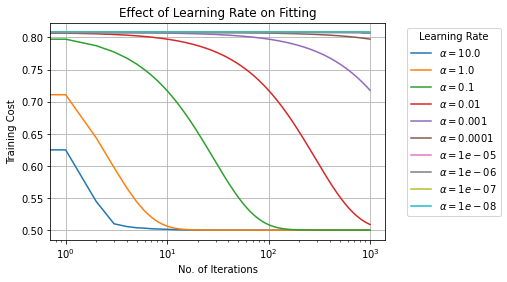

In [32]:
import matplotlib.pyplot as plt

learning_rates = [(x/(10**(i+1))) for i, x in enumerate([100]*10)]

fig, ax = plt.subplots()

for learning_rate in learning_rates:
    lr = LRGradDesc(X_train_norm, Y_train, learning_rate=learning_rate)(X_test_norm, Y_test, verbose=False)
    lr_list = list(map(lambda x: x[0], lr))
    ax.plot(list(range(len(lr_list))), lr_list, label=fr"$\alpha = {learning_rate}$")
    
ax.set_title("Effect of Learning Rate on Fitting")
ax.legend(title="Learning Rate", bbox_to_anchor=(1.05, 1))
ax.set_xlabel("No. of Iterations")
ax.set_xscale('log')
ax.set_ylabel("Training Cost")
ax.autoscale(True)
ax.grid()


# Analysis
Using the above figure as our source for analysis, we arrive to a few conclusions:
1. As the learning rate increases to around $10$, we begin to derive our optimal model.
2. As the learning rates decreases from around $10$, we begin to see that more iterations are required to converage and hence, derive our optimal model.
3. As the learning rates increases from around $10$, we begin to see divergent behaviour, indicating our model is underfitted and hence, is sub-optimal.

d) Compare your model with one using a machine learning library to compute logistic regression.

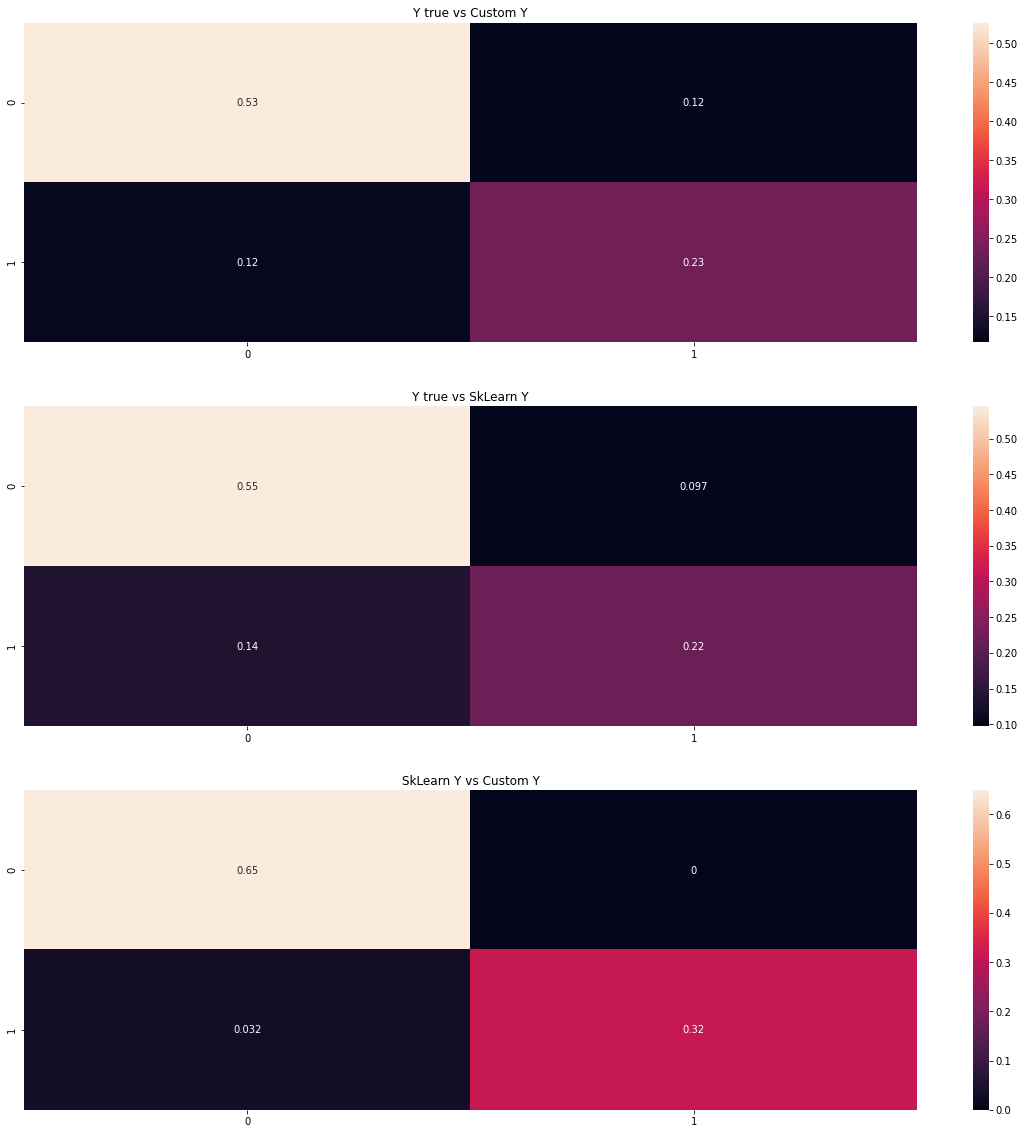

In [33]:
from sklearn import linear_model, metrics
import seaborn as sns

sk_clf = linear_model.LogisticRegression(random_state=22)
sk_clf.fit(X_train_norm, Y_train)
sk_clf_Y_pred = sk_clf.predict(X_test_norm) 

custom_weights = list(LRGradDesc(X_train_norm, Y_train)(X_test_norm, Y_test, verbose=False))[-1][-1]
custom_Y_pred = predict(X_test_norm, custom_weights)

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(3, 1, 1)
ax1.set_title("Y true vs Custom Y")
ax2 = fig.add_subplot(3, 1, 2)
ax2.set_title("Y true vs SkLearn Y")
ax3 = fig.add_subplot(3, 1, 3)
ax3.set_title("SkLearn Y vs Custom Y")

# Compare classifers predicted values against true values.
con_mat_custom = metrics.confusion_matrix(Y_test, custom_Y_pred, normalize='all')
con_mat_sklearn = metrics.confusion_matrix(Y_test, sk_clf_Y_pred, normalize='all')
# Compare the two classifiers.
con_mat_between = metrics.confusion_matrix(custom_Y_pred, sk_clf_Y_pred, normalize = 'all')
sns.heatmap(con_mat_custom, ax=ax1, annot=True)
sns.heatmap(con_mat_sklearn, ax=ax2, annot=True)
sns.heatmap(con_mat_between, ax=ax3, annot = True)


# Analysis

Using the confusion matrix to compare the values predicted by two classifiers, we can arrive at a few conclusions.
1. Our custom classifier predicts less true 0's than the SKLearn classifier.
2. Our custom classifier predicts more false 0's than the SkLearn classifier.
3. Our custom classifer predicts less true 1's than the SKLearn classifier.
4. Our custom classifier predicts more false 1's than the SKLearn classifier.

However, the SKLearn classifier does not signicantly outperform our custom classifer.

e) Retrain your model using three features of your choice. Compare both models using an ROC curve (you can use code from [here](https://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html#sphx-glr-auto-examples-ensemble-plot-feature-transformation-py) to draw the ROC curve).

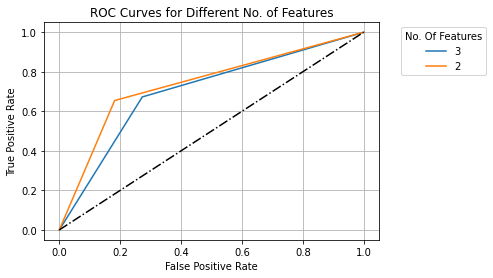

In [34]:
X_3_train, X_3_test, Y_3_train, Y_3_test = norm_init(number_of_features=3)
weights_3 = list(LRGradDesc(X_3_train, Y_3_train, weight_init=np.ones((3,)))(X_3_test, Y_3_test, verbose=False))[-1][-1]
Y_3_pred = predict(X_3_test, weights_3)

fp_rate_3,tp_rate_3, _ = metrics.roc_curve(Y_3_test, Y_3_pred)
fp_rate_2,tp_rate_2,  _ = metrics.roc_curve(Y_test, custom_Y_pred)

fig, ax = plt.subplots()

ax.plot(fp_rate_3, tp_rate_3, label="3")
ax.plot(fp_rate_2, tp_rate_2, label="2")
ax.plot(np.linspace(0, 1), np.linspace(0,1), "k-.")

ax.set_title("ROC Curves for Different No. of Features")
ax.legend(title="No. Of Features", bbox_to_anchor=(1.05, 1))
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.autoscale(True)
ax.grid()

# Analysis
Using the above ROC graph, we can arrive to the following conclusion(s).
1. Our model which uses 2 features outperforms our model which uses three features.


## **2. Multi-class classification using neural networks**

In this question you will experiment with a neural network in the context of text classification, where a document can belong to one out of several possible categories. The main goal for you is to try different hyperparameters in a systematic manner so that you can propose a network configuration that is properly justified. You will experiment with the [Reuters newswire](https://keras.io/api/datasets/reuters/), which can be loaded directly from Keras:

```python
from keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)
```

**Word Embeddings**


A recent breakthrough in the field of natural language processing is called [word embeddings](https://en.wikipedia.org/wiki/Word_embedding).

This is a technique where words are encoded as real-valued vectors in a high-dimensional space and where the similarity between words in terms of meaning translates to closeness in the vector space.

Words are mapped to vectors of continuous numbers. This is useful when working with natural language using neural networks as we require numbers as input.

Keras provides a convenient way to convert positive integer representations of words into word embeddings by means of an *Embedding layer*.

The layer takes arguments that define the mapping including the maximum number of expected words, also called the vocabulary size. The layer also allows you to specify the dimensionality for each word vector, which is called the output dimension.

We would like to use a word embedding representation for the Reuters dataset.

Let’s say that we are only interested in the first 5,000 most frequently used words in the dataset. Therefore, our vocabulary size will be 5,000. We can choose to use a 32-dimension vector to represent each word. Finally, we may choose to cap the maximum review length at 500 words. This will truncate reviews longer than that limit, and pad reviews shorter than that limit with empty words (0 values).

We load the Reuters dataset as follows:

In [35]:
import tensorflow as tf
from keras.datasets import reuters
from numpy.random import seed
seed(42)
tf.random.set_seed(42)

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=5000)

# Ignore deprecation warnings.
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

We would then use a Keras utility to truncate or pad the dataset to a length of 500 for each observation using the sequence.pad_sequences() function. 

To learn more why we need padding read [this article](https://developers.google.com/machine-learning/guides/text-classification/step-3) 

```python
X_train = sequence.pad_sequences(train_data, maxlen=500)
X_test = sequence.pad_sequences(test_data, maxlen=500)
```

Finally, later on, the first layer of our model would be an word embedding layer created using the Embedding class as follows:



```python
from keras.layers.embeddings import Embedding

Embedding(5000, 32, input_length=500)
```



a) As we load the data from the built-in keras function, it splits them into two subsets; however, it is recommended to split the data into three subsets such as:
``` 
70% train, 15% val, 15% test.
80% train, 10% val, 10% test.
60% train, 20% val, 20% test.
```
Use the mentioned ratios to split the data and train the model using these portions. For each one of your experiments, train the model and report the loss and accuracy of model on the training and validation set. (for more information check this [link](https://scikit-learn.org/stable/modules/learning_curve.html#:~:text=2.-,Learning%20curve,error%20or%20a%20bias%20error.))  


In [36]:
from sklearn import model_selection
from keras import models, Sequential, layers, preprocessing, optimizers, initializers, metrics
from tensorflow.keras import utils as np_utils
import pandas as pd
from IPython.display import display

def nn_init(train_size=0.7, validation_size=0.15, test_size=0.15):
    (train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=5000, test_split=(test_size + validation_size))
    test_size_scaled = test_size / (validation_size + test_size)
    
    validation_data, test_data, validation_labels, test_labels = model_selection.train_test_split(test_data, test_labels, test_size=test_size_scaled)
    
    train_data = preprocessing.sequence.pad_sequences(train_data, maxlen=500)
    validation_data = preprocessing.sequence.pad_sequences(validation_data, maxlen=500)
    test_data = preprocessing.sequence.pad_sequences(test_data, maxlen=500)
    
    train_labels = np_utils.to_categorical(train_labels, 46)
    validation_labels = np_utils.to_categorical(validation_labels, 46)
    test_labels = np_utils.to_categorical(test_labels, 46)
    
    return (train_data, train_labels), (validation_data, validation_labels), (test_data, test_labels) 

def nn_build(input_dim=5000, output_dim=32, input_length=500, n_of_layers=4, n_of_nodes=[16, 16, 16, 16], learning_rate=0.01, n_of_categories=46, regularizer=None):
    model = Sequential()
    initializer = initializers.RandomNormal(seed=42)
    model.add(layers.Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length, embeddings_initializer=initializer, embeddings_regularizer=regularizer))
    model.add(layers.Flatten())
    
    for layer_no in range(n_of_layers):
        model.add(layers.Dense(n_of_nodes[layer_no], activation=tf.nn.relu, kernel_initializer=initializer, activity_regularizer=regularizer))
    
    model.add(layers.Dense(n_of_categories, activation=tf.nn.softmax, kernel_initializer=initializer, activity_regularizer=regularizer))
    optimizer = optimizers.RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=[metrics.CategoricalAccuracy(), metrics.MSE])
    return model

def nn_train(train_data, train_labels, validation_data, validation_labels, regularizer = None, n_of_layers=4, n_of_nodes=[16,16,16, 16], learning_rate=0.01, n_of_epochs=4, batch_size=None):
    model = nn_build(n_of_categories=train_labels.shape[1], n_of_layers=n_of_layers, n_of_nodes=n_of_nodes, learning_rate=learning_rate, regularizer=regularizer)
    History = model.fit(train_data, train_labels, validation_data=(validation_data, validation_labels), epochs=n_of_epochs, batch_size=batch_size)
    return (np.array(History.history[key]).mean() for key in ["loss", "categorical_accuracy", "val_loss", "val_categorical_accuracy"])
    

def nn_run_splits(splits = [[0.7, 0.15, 0.15], [0.8, 0.1, 0.1], [0.6, 0.2, 0.2]]):
    for split in splits:
        ((tnd, tnl), (vdd, vdl), (ttd, ttl)) = nn_init(*split)
        print(f"Current Split = {split}")
        loss, acc, val_loss, val_acc = nn_train(tnd, tnl, vdd, vdl)
        print("Final Report")
        print(f"Loss = {loss:.2f}, Accuracy = {acc:.2f}, Validation Loss = {val_loss:.2f}, Validation Accuracy = {val_acc:.2f}")
        
nn_run_splits()
    

Current Split = [0.7, 0.15, 0.15]
Epoch 1/4
246/246 [==============================] - 14s 8ms/step - loss: 2.3328 - categorical_accuracy: 0.3601 - mean_squared_error: 0.0159 - val_loss: 1.8018 - val_categorical_accuracy: 0.5386 - val_mean_squared_error: 0.0121
Epoch 2/4
246/246 [==============================] - 1s 6ms/step - loss: 1.6183 - categorical_accuracy: 0.5712 - mean_squared_error: 0.0112 - val_loss: 1.6923 - val_categorical_accuracy: 0.5819 - val_mean_squared_error: 0.0112
Epoch 3/4
246/246 [==============================] - 1s 6ms/step - loss: 1.4057 - categorical_accuracy: 0.6131 - mean_squared_error: 0.0100 - val_loss: 1.6786 - val_categorical_accuracy: 0.5873 - val_mean_squared_error: 0.0110
Epoch 4/4
246/246 [==============================] - 2s 6ms/step - loss: 1.2454 - categorical_accuracy: 0.6596 - mean_squared_error: 0.0088 - val_loss: 1.8518 - val_categorical_accuracy: 0.5855 - val_mean_squared_error: 0.0113
Final Report
Loss = 1.58, Accuracy = 0.57, Validation Los

b) Experiment with different hyperparameters and report your best accuracy found. The most important hyperparameters that you need to experiment with in this question part are: 

* number of layers
* nodes per hidden layer
* learning rate
* number of epochs

To select the best hyper-parameter, draw the loss and accuracy curve.

Epoch 1/4
246/246 [==============================] - 2s 6ms/step - loss: 48.8243 - categorical_accuracy: 0.3182 - mean_squared_error: 0.0190 - val_loss: 2.4632 - val_categorical_accuracy: 0.3373 - val_mean_squared_error: 0.0179
Epoch 2/4
246/246 [==============================] - 1s 5ms/step - loss: 2.4170 - categorical_accuracy: 0.3524 - mean_squared_error: 0.0177 - val_loss: 2.4495 - val_categorical_accuracy: 0.3373 - val_mean_squared_error: 0.0179
Epoch 3/4
246/246 [==============================] - 1s 5ms/step - loss: 2.4349 - categorical_accuracy: 0.3454 - mean_squared_error: 0.0179 - val_loss: 2.4763 - val_categorical_accuracy: 0.3373 - val_mean_squared_error: 0.0179
Epoch 4/4
246/246 [==============================] - 1s 5ms/step - loss: 2.4260 - categorical_accuracy: 0.3539 - mean_squared_error: 0.0178 - val_loss: 2.4645 - val_categorical_accuracy: 0.3373 - val_mean_squared_error: 0.0179
Epoch 1/4
246/246 [==============================] - 2s 6ms/step - loss: 64.2537 - categori

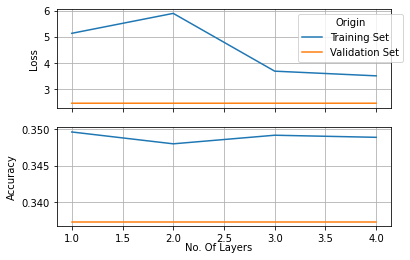

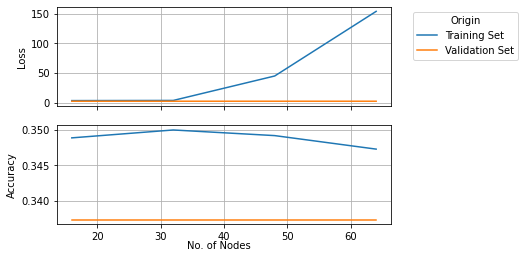

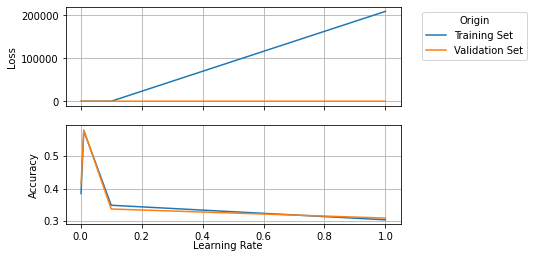

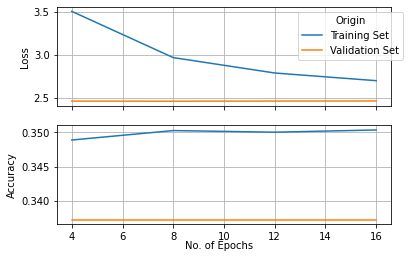

In [37]:
import matplotlib.pyplot as plt

((tnd, tnl), (vdd, vdl), (ttd, ttl)) = nn_init()

def nn_plot(x_label, x_vals=[x+1 for x in range(4)], n_of_layers = [4] * 4, n_of_nodes = [[16]*4]*4, learning_rate=[0.1]*4, n_of_epochs=[4]*4, iterations=4, batch_size=[32 for x in range(4)], regularizers=[None]*4):
    fig, axs = plt.subplots(2, sharex=True)

    loss_acc_data = {
        "loss": [],
        "val_loss": [],
        "acc": [],
        "val_acc": []
    }
    
    for i in range(iterations):
        loss, acc, val_loss, val_acc = nn_train(
            tnd, tnl, vdd, vdl, 
            n_of_layers=n_of_layers[i], 
            n_of_nodes=n_of_nodes[i], 
            learning_rate=learning_rate[i], 
            n_of_epochs=n_of_epochs[i],
            batch_size=batch_size[i],
            regularizer=regularizers[i]
        )
        loss_acc_data["loss"].append(loss)
        loss_acc_data["val_loss"].append(val_loss)
        loss_acc_data["acc"].append(acc)
        loss_acc_data["val_acc"].append(val_acc)
    
    fig.text(0.5, 0.04, x_label, ha='center')
    print("Loss and Accuracy", f"No. of Nodes = {n_of_nodes}", f"No. of Layers = {n_of_layers}", f"No. of Learning Rate = {learning_rate}", f"No. of Epochs = {n_of_epochs}", sep="\n")
    axs[0].plot(x_vals, loss_acc_data["loss"], label="Training Set")
    axs[0].plot(x_vals, loss_acc_data["val_loss"], label="Validation Set")
    axs[0].set_ylabel("Loss")
    axs[1].plot(x_vals, loss_acc_data["acc"], label="Training Set")
    axs[1].plot(x_vals, loss_acc_data["val_acc"], label="Validation Set")
    axs[1].set_ylabel("Accuracy")
    axs[0].legend(title="Origin", bbox_to_anchor=(1.05, 1))
    axs[0].grid()
    axs[1].grid()

# Find optimal Number of Layers
nn_plot("No. Of Layers", x_vals=[(x+1) for x in range(4)], n_of_layers=[(x+1) for x in range(4)], n_of_nodes = [[16]*(x+1) for x in range(4)])
# Find optimal Number of Nodes
nn_plot("No. of Nodes", x_vals=[16 * (x+1) for x in range(4)], n_of_layers=[4 for i in range(4)],n_of_nodes=[[16 * (x+1)] * 4 for x in range(4)])
# Find optimal Learning Rate
nn_plot("Learning Rate", x_vals=[(1/(10 ** x)) for x in range(4)], learning_rate=[(1/(10 ** x)) for x in range(4)])
# Find optimal number of epochs
nn_plot("No. of Epochs", x_vals=[4*(x+1) for x in range(4)], n_of_epochs=[4*(x+1) for x in range(4)])


# Analysis
Using the above charts, we can arrive to a few conclusions as to what the optimal hyperparameters are:
1. More layers produce a lower cost and a higher accuracy. We should have more than 4 layers to derive our optimal solution. 
2. When we have more ~ 32 nodes, we increase our accuracy and decrease our loss. Having ~ 32 node per layer seems to be optimal.
3. A learning rate of ~ 0.02 seems to derive our optimal model.
4. Our accuracy increases and our loss decreases as the number of epochs increase to 16. We should train our model with slightly more than 16 epochs to derive our optimal solution. 

c) Describe how your convergence changes when you vary the size of your mini-batch. A plot showing cost in terms of number of epochs would be enough. Discuss the reasons for this.


In [38]:
nn_plot("Batch Size", 
                  x_vals=[8*(x+1) for x in range(4)],
                  batch_size=[8 * (x+1) for x in range(4)],
                  learning_rate=[0.02]*4, 
                  n_of_epochs=[16]*4, 
                  n_of_layers=[8]*4, 
                  n_of_nodes=[[32]*8] * 4, 
                  iterations=4)

NameError: ignored

# Analysis

Using the above figure, we can begin to reason how the convergence will change depending on the batch size.

1. A low batch size will take longer to converge since less weights are being updated every iteration of BGD. 
2. A higher batch size will take a smaller amount of time to converge since more weights are being updated every iteration of BGD.

d) Experiment with different regularization options (e.g. L2 and dropout).You may need to make your network larger in case you don’t find much benefits from applying regularization.

Note: we recommend you to control your initialization parameters by means of a seed https://keras.io/api/layers/initializers/ .

In [ ]:
regularizers = [tf.keras.regularizers.l1(1e-5), tf.keras.regularizers.l2(1e-7), tf.keras.regularizers.l1_l2(42e-7, 42e-7), lambda x: 42e-10 * tf.reduce_sum(tf.pow(x, 3))]
nn_plot("Batch Size", 
                  x_vals=["l1", "l2", "l1_l2", "custom"],
                  batch_size=[32]*4,
                  learning_rate=[0.02]*4, 
                  n_of_epochs=[16]*4, 
                  n_of_layers=[8]*4, 
                  n_of_nodes=[[32]*8] * 4, 
                  regularizers=regularizers,
                  iterations=4)

# Analysis
Using the above diagram, its evident that the L2 regularizers increases the overall accuracy of the model and outperforms the other regularizers used.

## **3. Computational graph (no code involved)**

This question aims at checking your understanding on defining arbitrary network architectures and compute any derivative involved for optimization.

Consider a neural network with N input units, N output units, and K hidden units. The activations are computed as follows:

$$
\begin{array}{l}
\mathbf{z}=\mathbf{W}^{(1)} \mathbf{x}+\mathbf{b}^{(1)} \\
\mathbf{h}=\sigma(\mathbf{z}) \\
\mathbf{y}=\mathbf{x}+\mathbf{W}^{(2)} \mathbf{h}+\mathbf{b}^{(2)}
\end{array}
$$

where $\sigma$ denotes the logistic function, applied elementwise. The cost involves a squared difference with the target $\mathbf{s}$ (with a 0.5 factor) and a regularization term that accounts for the dot product with respect to an external vector $\mathbf{r}$. More concretely:
$$
\begin{array}{l}
\mathcal{E}=\mathcal{R}+\mathcal{S} \\
\mathcal{R}=\mathbf{\lambda} \mathbf{|W|} \\
\mathcal{S}=\frac{1}{2}\|\mathbf{y}-\mathbf{s}\|^{2}
\end{array}
$$


a) Draw the computation graph relating $\mathbf{x}$, $\mathbf{z}$, $\mathbf{h}$, $\mathbf{y}$, $\mathcal{R}$, $\mathcal{S}$, and $\mathcal{E}$.

![Computatation Graph](https://docs.google.com/uc?export=download&id=1qiVhH3DVl-pfZSw6DW0w_2s4B8dIeL1x)

b) Derive the backpropagation equations for computing $\partial \mathcal{E} / \partial W^{(1)}$. To make things simpler, you may use $\sigma'$ to denote the derivative of the ReLU function.

![Backpropagation Equation](https://docs.google.com/uc?export=download&id=1zwFUoBc5VOBl_ROczSPlGbY-RoKiXywM)

## **4. Tuning generalization**

In this question you will construct a neural network to classify a large set of low resolution images. Differently from Q2, in this case we suggest you a neural network to start experimenting with, but we would like you to describe the behavior of the network as you modify certain parameters. You will be reproducing some concepts mentioned during the lectures, such as when we show how generalization changes as the number of parameters are changed.

a) Use the CIFAR-10 dataset (available from Keras)

```python
from keras.datasets import cifar10
(x_train_original, y_train_original), (x_test_original, y_test_original) =
cifar100.load_data(label_mode='fine')
```
to train a neural network with two hidden layers using the logistic activation function and RELU, with 500 and 200 hidden nodes, respectively. The output layer should be defined according to the nature of the targets. Similar to the second question, split the data into train, validation and test sets.


CIFAR10 contains colour images that are 32x32 pixels. At first glance it may seem like there are only 32×32=1024 features per image, but there are red, blue and green channels in the image, which means each image is actually 3×32×32=3072 features.

Usually, these channels are arranged as three separate 32x32 pixel images, rather than a single 32x32 image with RGB pixels.

In order to input these into an MLP, we need to flatten the channels and pixel arrays to form an array of shape (num_samples, 3072), just like with MNIST. We can do this in python like so:
```
x_train = x_train.reshape(-1, 3072)
x_test = x_test.reshape(-1, 3072)
```

a) Generate a plot that shows average precision for training and test sets as a function of the
number of epochs. Indicate what a reasonable number of epochs should be.

In [ ]:
from keras.datasets import cifar100
from keras.backend import clear_session
from keras.models import Sequential
from keras.layers import Dense, InputLayer
from keras.metrics import Precision, Accuracy
from tensorflow.keras.utils import to_categorical
from keras.initializers import RandomNormal
import matplotlib.pyplot as plt
import numpy as np
import tensorflow
from numpy.random import seed
from sklearn.model_selection import train_test_split
import re

seed(42)
tensorflow.random.set_seed(42)

clear_session()

def nn_2_init(test_size):
  (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

  if (test_size < 1 and test_size > 0):
    x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=test_size)

  x_train = x_train.reshape((50000, 32 * 32 * 3, ))
  x_train = x_train.astype('float32') / 255

  x_test = x_test.reshape((int(10000 * test_size), 32 * 32 * 3,))
  x_test = x_test.astype('float32') / 255

  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)

  return x_train, x_test, y_train, y_test

def nn_2_build(input_dim, output_dim, no_of_nodes) -> Sequential:
  model = Sequential()
  initializer = RandomNormal(seed=42)

  # Input Layer
  model.add(InputLayer(input_shape=(input_dim,)))

  # Hidden Layers
  for i in range(len(no_of_nodes)):
    model.add(Dense(no_of_nodes[i], activation="relu", kernel_initializer=initializer))

  # Output Layer
  model.add(Dense(output_dim, activation='softmax'))

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[Precision(), Accuracy()])

  return model

def nn_2_train(x_train, x_test, y_train, y_test, no_of_epochs, no_of_nodes, metrics_to_track=["precision", "val_precision", "accuracy", "val_accuracy", "loss", "val_loss"]):
  model = nn_2_build(x_train.shape[1], y_train.shape[1], no_of_nodes)
  metrics = model.fit(x_train, y_train, epochs=no_of_epochs, validation_data=(x_test,y_test))
  metrics_to_track = [key for key in metrics.history if re.sub(r'_\d+', "", key) in metrics_to_track]
  return {re.sub(r'_\d+', "", key): np.array(metrics.history[key]).mean() for key in metrics_to_track}

def nn_2_plot(x_lbl, x_vals, metrics_to_track=["precision", "val_precision"], no_of_epochs=[4]*4, no_of_nodes=[[500,200]]*4, test_size=[1]*4):
  
  metrics = {metric_name: [] for metric_name in metrics_to_track}

  for i in range(len(x_vals)):
    if not len(set(test_size)) or not i:
      data = nn_2_init(test_size[i])

    metrics_temp = nn_2_train(*data, no_of_epochs=no_of_epochs[i], no_of_nodes=no_of_nodes[i])
    metrics["precision"].append(metrics_temp["precision"])
    metrics["val_precision"].append(metrics_temp["val_precision"])
    metrics["accuracy"].append(metrics_temp["accuracy"])
    metrics["val_accuracy"].append(metrics_temp["val_accuracy"])

  fig, ax = plt.subplots()

  for metric_name in metrics:
    metric_values = metrics[metric_name]
    if metric_values:
      ax.plot(x_vals, metric_values, label=metric_name)

  ax.set_xlabel(x_lbl)
  ax.legend(title="Metric Type")
  ax.grid()
  ax.autoscale()

nn_2_plot("Number of Epochs", x_vals=[4 * (i+1) for i in range(4)], no_of_epochs=[4 * (i+1) for i in range(4)])

# Analysis

When the model uses around 8-12 epochs, we achieve optimal precision.

b) Generate a plot that shows average precision for training and validation sets as a function of the number of weights/parameters (# hidden nodes). For this question part, you will be modifying the architecture that was given to you as a starting point.

In [ ]:
nn_2_plot("Number of Hidden Nodes", x_vals=[(i+2)*100 for i in range(8)], no_of_nodes=[[(i+2) * 100] * 4 for i in range(8)], no_of_epochs=[10 for i in range(8)])

c) Generate the plot for accuracy and loss of training and validation as a function of the number of instances in the training set. For this question part, you will be modifying your training set. For instance, you can follow the Q2 suggested ratios or run 10 experiments where you first use a random 10% of the training data, a second experiment where you use a random 20% of the training data, and so on until
you use the entire training set. Keep the network hyperparameters constant during your experiments.

In [ ]:
nn_2_plot("Percentage of Training Set", x_vals=[(i+1)*0.1 for i in range(9)], no_of_nodes=[[600]*3]*9, no_of_epochs=[10 for i in range(9)], test_size=[(i+1)*0.1 for i in range(9)], metrics_to_track=["precision", "val_precision", "accuracy", "val_accuracy"])

d) Based on all your experiments above, define a network architecture and report accuracy and average precision for all classes.

In [ ]:
nn_2_plot("Iteration No.", x_vals=[(i+1) for i in range(4)], no_of_nodes=[[600]*3]*4, no_of_epochs=[10]*4, test_size=[0.6]*4, metrics_to_track=["precision", "val_precision", "accuracy", "val_accuracy"])

e) Can you improve test prediction performance by using an ensemble of neural networks?

# Answer
Yes. Since there exists a limited number of training instances, by using the prediction of multiple neural networks (an ensemble of neural networks), we would arrive at more accurate results.